In [29]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

In [30]:
df = pd.read_csv("Datos/Transformados/Accion_columna.csv")

In [31]:
df.columns

Index(['fecha', 'AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX',
       'DIS', 'DOW', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD',
       'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V'],
      dtype='object')

In [32]:
cols_numericas = df.select_dtypes(include=[np.number]).columns
df_pct = df[cols_numericas].pct_change()

C:\Users\lande\AppData\Local\Temp\ipykernel_11436\2167787936.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_pct = df[cols_numericas].pct_change()


<Axes: >

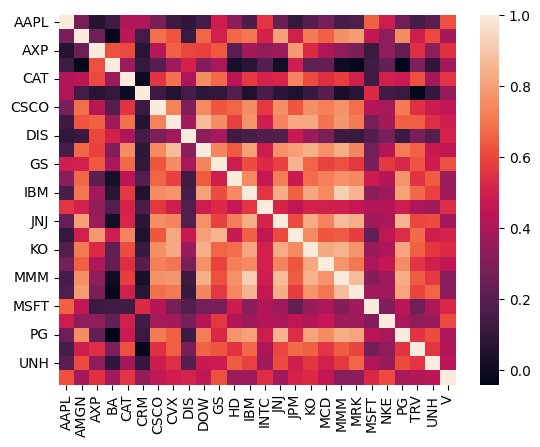

In [33]:
sns.heatmap(df_pct.corr())

In [34]:
# Calcula la matriz de correlaciones
corr_matrix = df_pct.corr()

# Encuentra los pares con menor correlación absoluta (excluyendo la diagonal)
corr_abs = corr_matrix.abs()
np.fill_diagonal(corr_abs.values, np.nan)

# Suma de correlaciones por activo (cuanto menor, más diversificado)
diversificacion = corr_abs.sum().sort_values()

# Selecciona los tres activos con menor suma de correlaciones
activos_diversificados = diversificacion.head(3).index.tolist()
print("Activos recomendados para diversificar:", activos_diversificados)

Activos recomendados para diversificar: ['CRM', 'BA', 'DIS']


<Axes: >

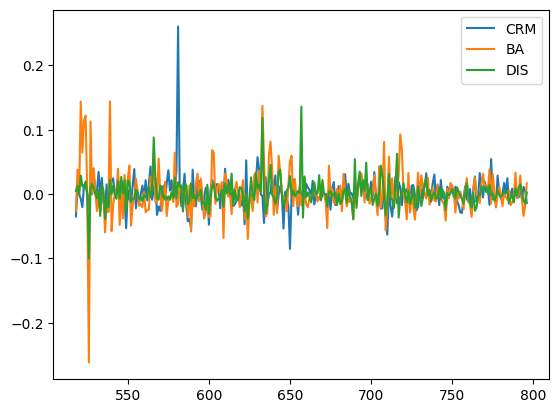

In [35]:
dfc = df_pct[activos_diversificados]
dfc.plot()

<Axes: >

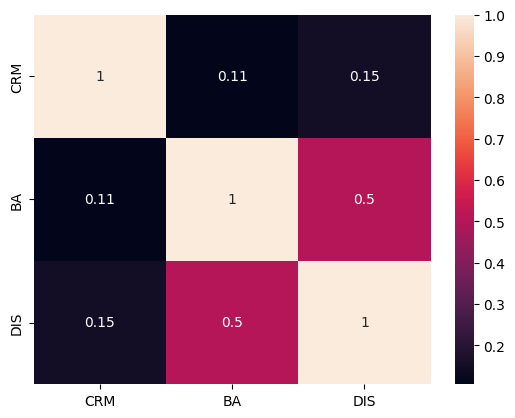

In [36]:
sns.heatmap(dfc.corr(),annot=True)

In [37]:
def rentabilidad_anualizada(r_diaria, n=252):
    return (np.prod(1 + r_diaria) ** (n / len(r_diaria))) - 1
for ticker in activos_diversificados:
    r_diaria = df[ticker].pct_change().dropna()
    datos_ticker = df[ticker].dropna()
    if not r_diaria.empty and len(datos_ticker) > 1:
        rent_media = r_diaria.mean() * 100
        rent_activa = (datos_ticker.iloc[-1] - datos_ticker.iloc[0]) / datos_ticker.iloc[0] * 100
        rent_anual = rentabilidad_anualizada(r_diaria, 252) * 100
        print(f"\nAcción: {ticker}")
        print(f"Rentabilidad media diaria: {rent_media:.2f}%")
        print(f"Rentabilidad activa del periodo: {rent_activa:.2f}%")
        print(f"Rentabilidad anualizada: {rent_anual:.2f}%")


Acción: CRM
Rentabilidad media diaria: 0.13%
Rentabilidad activa del periodo: 33.87%
Rentabilidad anualizada: 30.14%

Acción: BA
Rentabilidad media diaria: 0.23%
Rentabilidad activa del periodo: 60.01%
Rentabilidad anualizada: 52.90%

Acción: DIS
Rentabilidad media diaria: 0.16%
Rentabilidad activa del periodo: 49.34%
Rentabilidad anualizada: 43.65%


C:\Users\lande\AppData\Local\Temp\ipykernel_11436\3547996840.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  r_diaria = df[ticker].pct_change().dropna()


In [38]:
for ticker in activos_diversificados:
    vol_diaria = df[ticker].pct_change().std()
    vol_anual = vol_diaria * np.sqrt(252)
    print(f"\nAcción: {ticker}")
    print(f"Volatilidad diaria: {vol_diaria:.4f}")
    print(f"Volatilidad anualizada: {vol_anual:.4f}")


Acción: CRM
Volatilidad diaria: 0.0252
Volatilidad anualizada: 0.4005

Acción: BA
Volatilidad diaria: 0.0361
Volatilidad anualizada: 0.5732

Acción: DIS
Volatilidad diaria: 0.0206
Volatilidad anualizada: 0.3267


C:\Users\lande\AppData\Local\Temp\ipykernel_11436\2582152120.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  vol_diaria = df[ticker].pct_change().std()


**Rentabilidad anualizada:** $r_{anualizada} = (1 + r_{activa})^n-1$

**Rentabilidad de la cartera:** $R\cdot X^T$

**Covarianza anualizada:** $M_{cov-anualizada} = M_{cov} \cdot 252 $

**Volatilidad de la cartera:** $\sigma_{cartera} = \sqrt{X \cdot M_{cov-anualizada} \cdot X^T}$

**Rentabilidad acumulada:** $R_{acu} = (1+RC_1)\cdot(1+RC_2)\cdot ... \cdot (1+RC_m) $

In [39]:
def volatilidad_cartera(pesos, datos, tickers):
    rendimientos = pd.DataFrame({ticker: df[ticker].pct_change() for ticker in tickers})
    cov_anual = rendimientos.cov() * 252
    return np.sqrt(np.dot(pesos, np.dot(cov_anual, pesos.T)))

In [40]:
pesos = np.array([1/3, 1/3, 1/3])
rendimientos = pd.DataFrame({ticker: df[ticker].pct_change() for ticker in activos_diversificados})
rentabilidad_media_diaria = (rendimientos.mean() @ pesos)
rentabilidad_anualizada_cartera = ((1 + rentabilidad_media_diaria) ** 252) - 1
volatilidad_anualizada_cartera = volatilidad_cartera(pesos, df, activos_diversificados)
print(f"Rentabilidad anualizada de la cartera: {rentabilidad_anualizada_cartera:.4f}")
print(f"Volatilidad anualizada de la cartera: {volatilidad_anualizada_cartera:.4f}")

Rentabilidad anualizada de la cartera: 0.5652
Volatilidad anualizada de la cartera: 0.3114


C:\Users\lande\AppData\Local\Temp\ipykernel_11436\2098530952.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rendimientos = pd.DataFrame({ticker: df[ticker].pct_change() for ticker in activos_diversificados})


In [41]:
rendimientos_cartera = rendimientos @ pesos
rentabilidad_acumulada = (1 + rendimientos_cartera).prod() - 1
print(f"Rentabilidad acumulada de la cartera: {rentabilidad_acumulada:.4f}")

Rentabilidad acumulada de la cartera: 0.5564


C:\Users\lande\AppData\Local\Temp\ipykernel_11436\1692571454.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  r = df[ticker].pct_change().mean() * 252
C:\Users\lande\AppData\Local\Temp\ipykernel_11436\1692571454.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  v = df[ticker].pct_change().std()* np.sqrt(252)


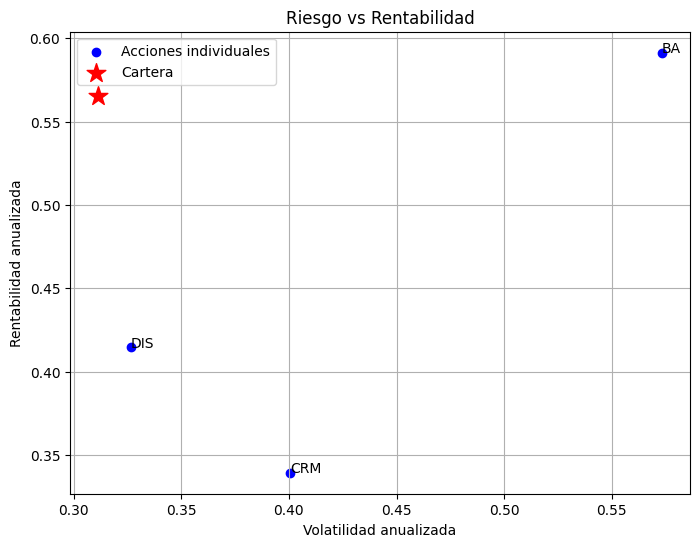

In [42]:
riesgos = []
rentabilidades = []
for ticker in activos_diversificados:
    r = df[ticker].pct_change().mean() * 252
    v = df[ticker].pct_change().std()* np.sqrt(252)
    rentabilidades.append(r)
    riesgos.append(v)
plt.figure(figsize=(8,6))
plt.scatter(riesgos, rentabilidades, c='blue', label='Acciones individuales')
plt.scatter(volatilidad_anualizada_cartera, rentabilidad_anualizada_cartera, c='red', label='Cartera', marker='*', s=200)
for i, ticker in enumerate(activos_diversificados):
    plt.text(riesgos[i], rentabilidades[i], ticker)
plt.xlabel('Volatilidad anualizada')
plt.ylabel('Rentabilidad anualizada')
plt.title('Riesgo vs Rentabilidad')
plt.legend()
plt.grid(True)
plt.show()